## Loading of Miller ECoG data of motor imagery

includes some visualizations

In [61]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [62]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [63]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[2][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper: 

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior. 

Both experiments: 
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV). 
* `dat['locs`]`: 3D electrode positions on the brain surface

In [ ]:
electrode_indexes = []
electrode_indexes.append([])
electrode_indexes.append([])

for subject_index, subject in enumerate(alldat):
  electrode_indexes[0].append([])
  electrode_indexes[1].append([])
  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes[0][subject_index].append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes[1][subject_index].append(gyrus_index)
  print("Subject {}:\n  Precentral Gyrus: {}\n  Postcentral Gyrus: {}".format(	subject_index,
            electrode_indexes[0][subject_index],
            electrode_indexes[1][subject_index])
         )




# ERP of sensorimotor area

In [50]:
def plt_data(dat1, dat2):
  # data1[iroi][icondi][isub][timerange]
  # let's find the electrodes that distinguish tongue from hand movements
  # note the behaviors happen some time after the visual cue
  trange = np.arange(0, 2000)
  dat1 = dat1.mean(2)
  dat2 = dat2.mean(2)
  print(dat1.shape)
  roi_name = ['precentral gyrus', 'postcentral gyrus']
  motion_type = ['hand', 'tongue']

  plt.figure(figsize=(20, 10))
  for iroi in range(2):
    for imotion_type in range(2):
      print(imotion_type * 2 + iroi + 1)
      print(imotion_type)
      print(iroi)
      ax = plt.subplot(2, 2, imotion_type * 2 + iroi + 1)
      if imotion_type == 0:
        plt.plot(trange, dat1[iroi][0][:])
        plt.plot(trange, dat1[iroi][1][:])
      else:
        plt.plot(trange, dat2[iroi][0][:])
        plt.plot(trange, dat2[iroi][1][:])

      plt.title('ERP %s across subjs (%s)'%(motion_type[imotion_type],roi_name[iroi]))
      plt.xticks([0, 1000, 2000])
      plt.ylim([-1, 1])
  plt.show()


[-0.09921826 -0.08117664 -0.09636907 ... -0.16863011 -0.1801554
 -0.18124596]
[-0.2417355  -0.10508018 -0.54505038 ...  0.14058841  0.20090153
 -0.20528466]
[-0.10486583 -0.10471023 -0.11476983 ... -0.06497218 -0.0569712
 -0.05619304]
[0.08513485 0.11123541 0.14046459 ... 0.04286896 0.07897847 0.05982313]
[ 0.06000011  0.07885618  0.04672915 ... -0.04308873 -0.02716142
  0.01094127]
[-0.03560234 -0.02808768 -0.04510888 ... -0.27077212 -0.2780931
 -0.2948742 ]
[-0.12989983 -0.18604819 -0.20932155 ... -0.27068736 -0.20847959
 -0.14370552]
[-0.09128646 -0.0831333  -0.10568739 ... -0.12355712 -0.13209381
 -0.12726161]
[-0.20384371 -0.02390206 -0.47671017 ...  0.12594884  0.2488448
 -0.15625799]
[-0.13091166 -0.14445788 -0.15887618 ... -0.03459836 -0.03416479
 -0.03783079]
[-0.06847356 -0.04102923 -0.01618093 ...  0.06685075  0.08272448
  0.04539813]
[ 0.05087924  0.07428708  0.05312407 ... -0.12988062 -0.10540967
 -0.06374611]
[-0.10039435 -0.10997119 -0.12546273 ... -0.16351328 -0.1682024

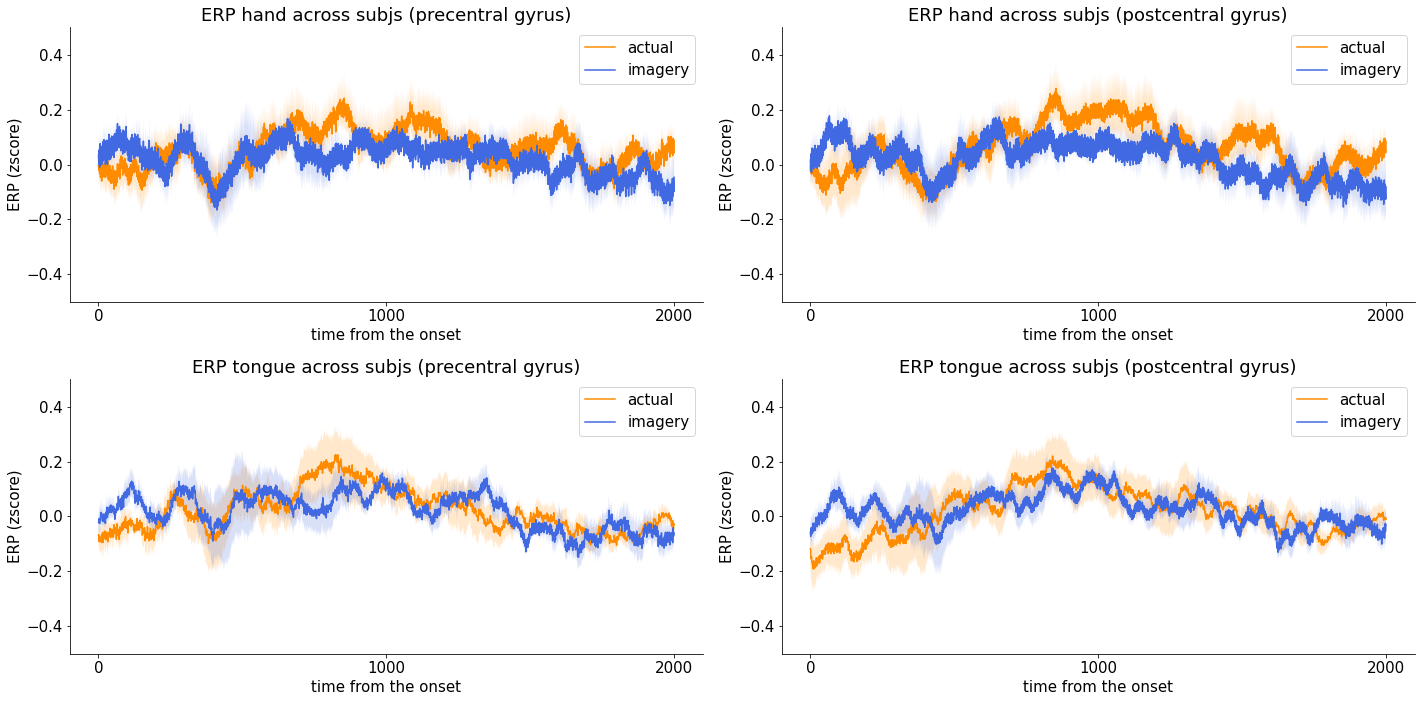

In [64]:
def plt_data(dat1, dat2):
  # data1[iroi][icondi][isub][timerange]
  # let's find the electrodes that distinguish tongue from hand movements
  # note the behaviors happen some time after the visual cue
  trange = np.arange(0, 2000)
  dat1_mean = dat1.mean(2)
  dat2_mean = dat2.mean(2)
  dat1_err= dat1.std(2) / np.sqrt(7)
  dat2_err= dat2.std(2) / np.sqrt(7)

  roi_name = ['precentral gyrus', 'postcentral gyrus']
  motion_type = ['hand', 'tongue']

  plt.figure(figsize=(20, 10))
  for iroi in range(2):
    for imotion_type in range(2):

      ax = plt.subplot(2, 2, imotion_type * 2 + iroi + 1)
      if imotion_type == 0:
        plt.plot(trange, dat1_mean[iroi][0][:], label = 'actual', color = 'darkorange')
        plt.plot(trange, dat1_mean[iroi][1][:], label = 'imagery', color = 'royalblue')
        plt.fill_between(trange, dat1_mean[iroi][0][:] + dat1_err[iroi][0][:], dat1_mean[iroi][0][:] - dat1_err[iroi][0][:],
                         facecolor = 'darkorange',
                         alpha = 0.2
                         )
        plt.fill_between(trange, dat1_mean[iroi][1][:] + dat1_err[iroi][1][:], dat1_mean[iroi][1][:] - dat1_err[iroi][1][:],
                         facecolor = 'royalblue',
                         alpha = 0.2
                         )
      else:
        plt.plot(trange, dat2_mean[iroi][0][:], label = 'actual', color = 'darkorange')
        plt.plot(trange, dat2_mean[iroi][1][:], label = 'imagery', color = 'royalblue')
        plt.fill_between(trange, dat2_mean[iroi][0][:] + dat2_err[iroi][0][:], dat2_mean[iroi][0][:] - dat2_err[iroi][0][:],
                         facecolor = 'darkorange',
                         alpha = 0.2
                         )
        plt.fill_between(trange, dat2_mean[iroi][1][:] + dat2_err[iroi][1][:], dat2_mean[iroi][1][:] - dat2_err[iroi][1][:],
                         facecolor = 'royalblue',
                         alpha = 0.2
                         )

      plt.title('ERP %s across subjs (%s)'%(motion_type[imotion_type],roi_name[iroi]))
      plt.legend()
      plt.xticks([0, 1000, 2000])
      plt.ylim([-0.5, 0.5])
      plt.xlabel('time from the onset')
      plt.ylabel('ERP (zscore)')
  plt.show()


def erp_for_each_sub(dat, ele_used):
  # quick way to get broadband power in time-varying windows
  from scipy import signal

  # V is the voltage data
  V = dat['V'].astype('float32')
  V = V[:, ele_used]

  # average the broadband power across all tongue and hand trials
  nt, nchan = V.shape
  nstim = len(dat['t_on'])

  trange = np.arange(0, 2000)
  ts = dat['t_on'][:, np.newaxis]

  ts = ts + trange

  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

  V_tongue = (V_epochs[dat['stim_id'] == 11]).mean(0) # average trials
  V_hand = (V_epochs[dat['stim_id'] == 12]).mean(0) # average trials

  erp_tongue = V_tongue.mean(1) # average the roi electrodes
  erp_hand = V_hand.mean(1) # average the roi electrodes
  
  return erp_tongue, erp_hand

erp_tongue = np.ones((2, 2, 7, 2000))
erp_hand = np.ones((2, 2, 7, 2000))

electrode_indexes = []
electrode_indexes.append([])
electrode_indexes.append([])

for subject_index, subject in enumerate(alldat):
  electrode_indexes[0].append([])
  electrode_indexes[1].append([])
  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes[0][subject_index].append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes[1][subject_index].append(gyrus_index)

for icondi in range(2): # 0 motion, 1 imagery
  for iroi in range(2): # 0 precentral gyrus, 1 postcentral gyrus
    for isub in range(7):
      erp_tongue[iroi][icondi][isub], erp_hand[iroi][icondi][isub] = erp_for_each_sub(alldat[isub][icondi], electrode_indexes[iroi][isub])

plt_data(erp_hand, erp_tongue)

In [ ]:
print(alldat.shape)
print(dat1['hemisphere'])
print(dat1['lobe'])
print(alldat[1][0]['gyrus'])
print(dat1['Brodmann_Area'])
print(alldat.shape)

print(range(7))





(7, 2)
['Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum', 'Right Cerebrum']
['Temporal Lobe', 'Temporal Lobe', 'Temporal Lobe', 'Temporal Lobe', 'Temporal Lobe', 'Temporal Lobe', 'Temporal Lobe', 'Tempora

In [ ]:
46+64+48+48+64+64+64

14+82+66+42+30+53+43+6



336

In [ ]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
print(utils.tal2mni(locs))
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

In [ ]:
# quick way to get broadband power in time-varying windows
from scipy import signal

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
# V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [ ]:
# average the broadband power across all tongue and hand trials
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(0, 2000)
ts = dat1['t_on'][:, np.newaxis]
print(ts)
ts = ts + trange
print(ts)
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

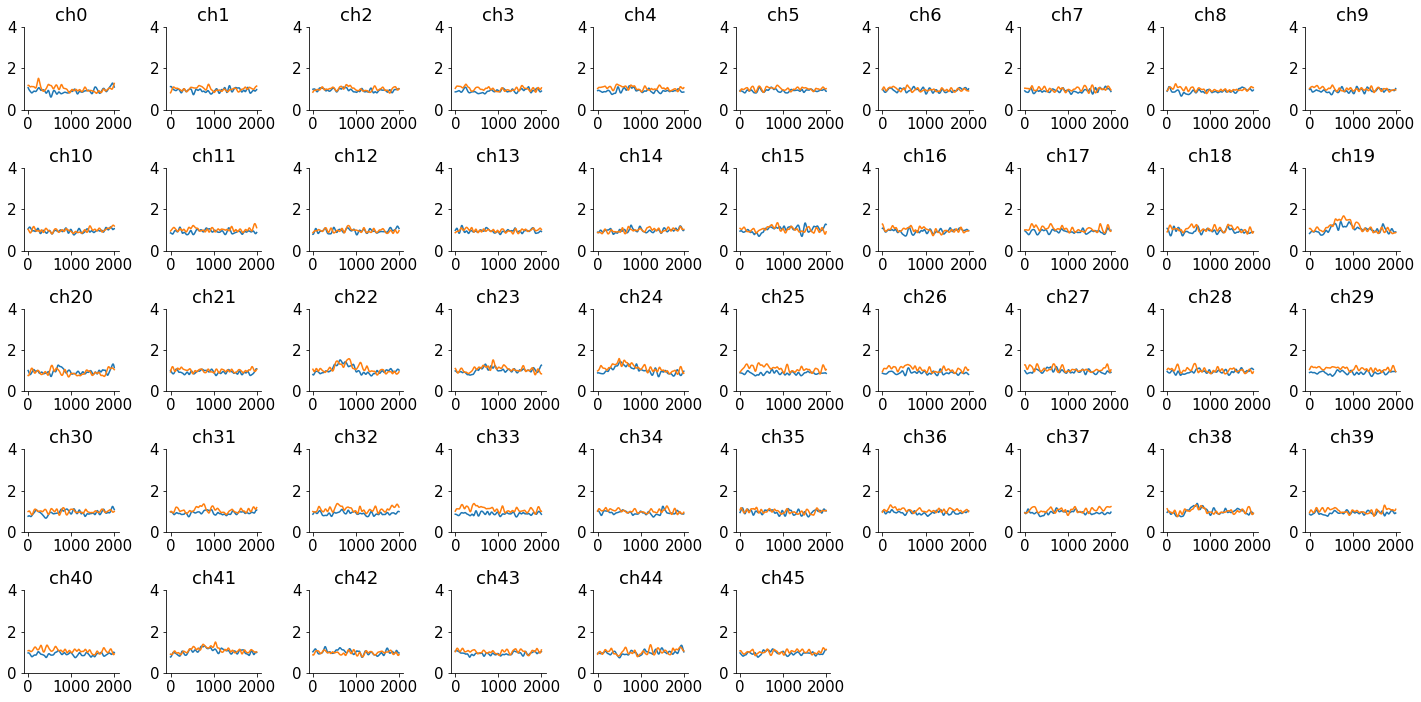

In [ ]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_tongue[:, j])
  plt.plot(trange, V_hand[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
plt.show()

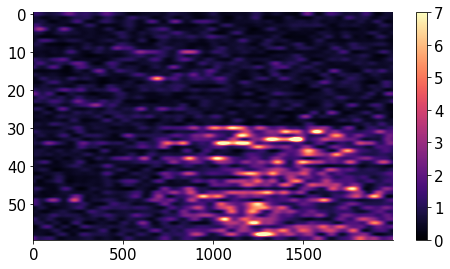

In [ ]:
# let's look at all the trials for electrode 20 that has a good response to hand movements
# we will sort trials by stimulus id
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 20].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

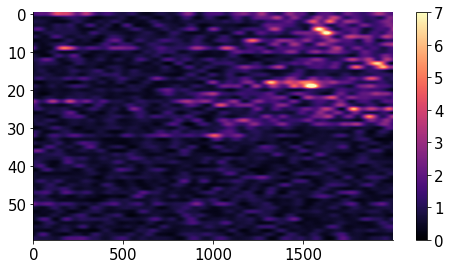

In [ ]:
# Electrode 42 seems to respond to tongue movements
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 42].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()